# **Step 1: Import Libraries and Load the Dataset**

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Suppress all warnings
import warnings
warnings.filterwarnings('ignore')

# Import GPU-accelerated libraries for boosting
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

warnings.filterwarnings('ignore')

# Load the dataset
file_path = '/kaggle/input/cdc-diabetes-health-indicators/diabetes_012_health_indicators_BRFSS2015.csv'
data = pd.read_csv(file_path)

# Display dataset overview
print("Dataset Shape:", data.shape)
print(data.info())
data.head()

ModuleNotFoundError: No module named 'lime'

# Step 2: Data Exploration

In [ ]:
# Check for missing values
missing = data.isnull().sum()
print("Missing values in each column:\n", missing)

Missing values in each column:
 Diabetes_012            0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64


# Step 3: Prepare Features and Split the Dataset

In [ ]:
# Split dataset into features (X) and target (y)
X = data.drop(columns=['Diabetes_012'])
y = data['Diabetes_012']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training Set Shape:", X_train.shape)
print("Test Set Shape:", X_test.shape)

Training Set Shape: (202944, 21)
Test Set Shape: (50736, 21)


# Step 4: Define a Function for Evaluation

In [ ]:
# Function to evaluate model performance with visual confusion matrix
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"Confusion Matrix for {type(model).__name__}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Step 5: Bagging - Random Forest


--- Bagging: Random Forest ---
Accuracy: 0.8426
Precision: 0.7966
Recall: 0.8426
F1 Score: 0.8084

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.97      0.91     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.49      0.20      0.28      7069

    accuracy                           0.84     50736
   macro avg       0.45      0.39      0.40     50736
weighted avg       0.80      0.84      0.81     50736



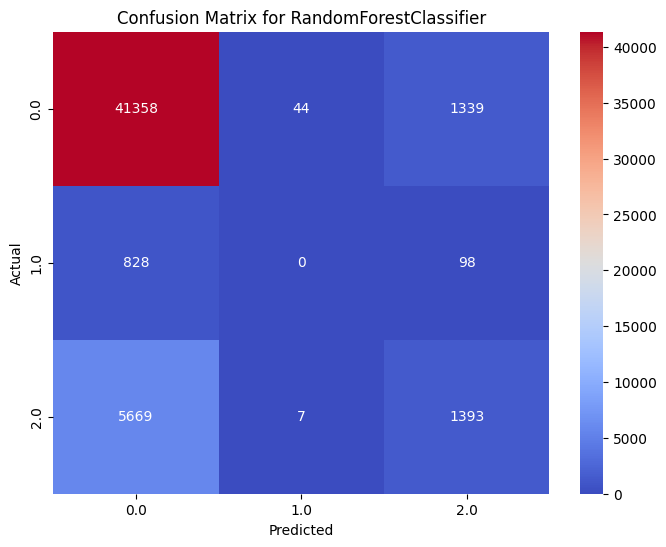

In [ ]:
print("\n--- Bagging: Random Forest ---")
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

# Step 6: Boosting - Gradient Boosting or XBoost


--- Boosting: XGBoost ---
Accuracy: 0.8487
Precision: 0.8040
Recall: 0.8487
F1 Score: 0.8114

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.55      0.19      0.28      7069

    accuracy                           0.85     50736
   macro avg       0.47      0.39      0.40     50736
weighted avg       0.80      0.85      0.81     50736



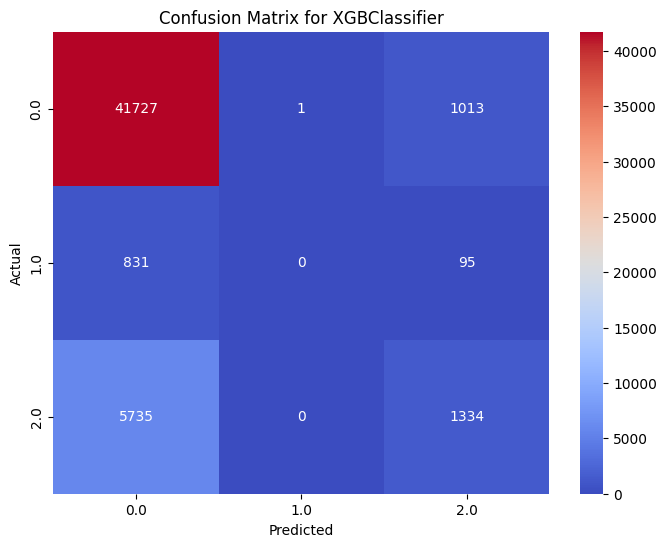

In [ ]:
print("\n--- Boosting: Gradient Boosting ---")
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)
evaluate_model(gb, X_test, y_test)

# LightGBM


--- Boosting: LightGBM ---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.003389 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171489
[LightGBM] [Info] Start training from score -4.003247
[LightGBM] [Info] Start training from score -1.970881
Accuracy: 0.8493
Precision: 0.8048
Recall: 0.8493
F1 Score: 0.8109

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.56      0.1

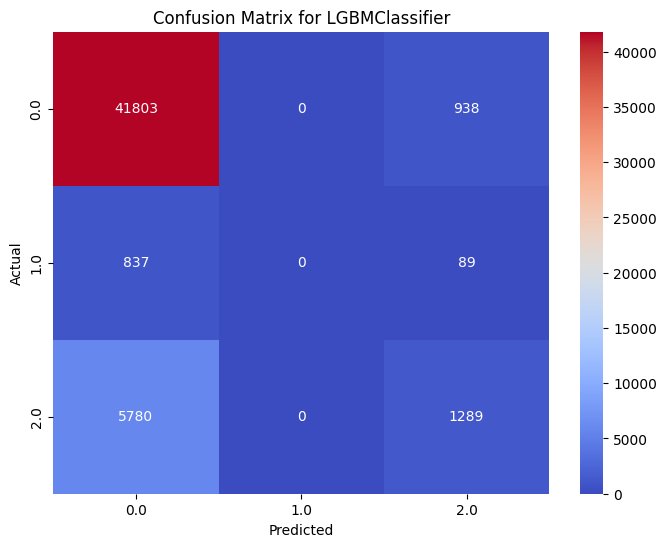

In [ ]:
# Boosting: LightGBM (GPU-accelerated)
print("\n--- Boosting: LightGBM ---")
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(device='gpu', random_state=42)  # Enable GPU
lgbm.fit(X_train, y_train)
evaluate_model(lgbm, X_test, y_test)

# Step 7: Stacking


--- Stacking ---
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.003348 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171489
[LightGBM] [Info] Start training from score -4.003247
[LightGBM] [Info] Start training from score -1.970881
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 162355, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kerne

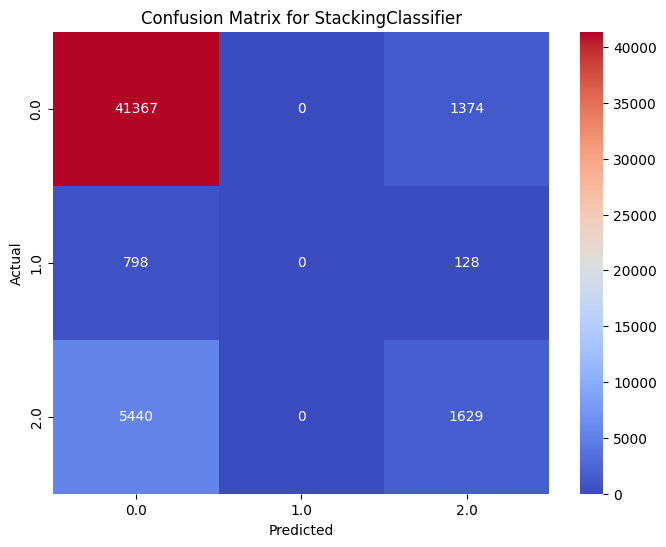

In [ ]:
print("\n--- Stacking ---")
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]
meta_model = LogisticRegression()
from sklearn.ensemble import StackingClassifier
stacking = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)
stacking.fit(X_train, y_train)
evaluate_model(stacking, X_test, y_test)

# Step 8: Voting


--- Voting Classifier ---

Hard Voting:
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.003448 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171489
[LightGBM] [Info] Start training from score -4.003247
[LightGBM] [Info] Start training from score -1.970881
Accuracy: 0.8495
Precision: 0.8049
Recall: 0.8495
F1 Score: 0.8079

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       

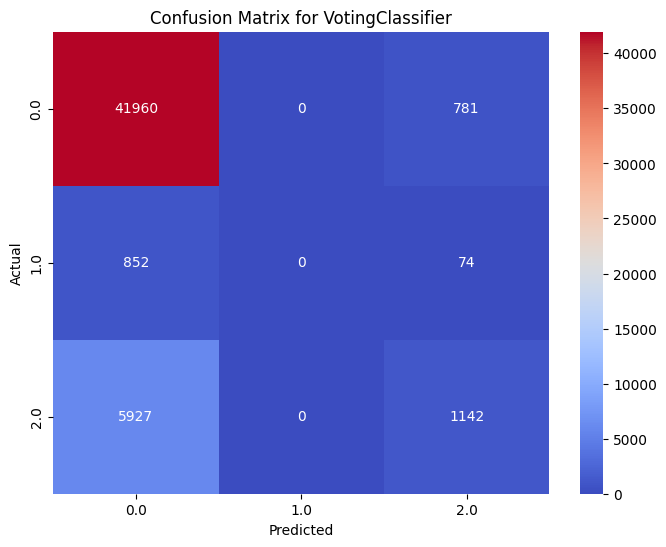


Soft Voting:
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.003386 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171489
[LightGBM] [Info] Start training from score -4.003247
[LightGBM] [Info] Start training from score -1.970881
Accuracy: 0.8492
Precision: 0.8047
Recall: 0.8492
F1 Score: 0.8110

Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92     42741
         1.0       0.00      0.00      0.00       926
         2.0       0.55      0.18      0.28   

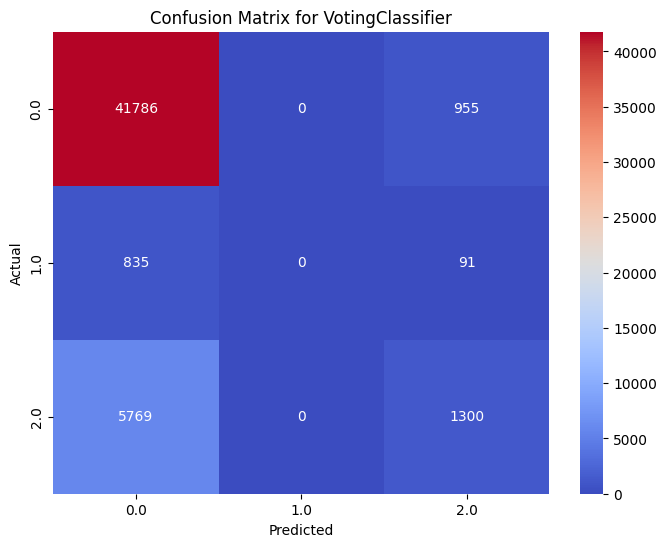

In [ ]:
print("\n--- Voting Classifier ---")
base_models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('svc', SVC(probability=True, random_state=42))
]
voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting='soft')

# Hard Voting
print("\nHard Voting:")
voting_hard.fit(X_train, y_train)
evaluate_model(voting_hard, X_test, y_test)

# Soft Voting
print("\nSoft Voting:")
voting_soft.fit(X_train, y_train)
evaluate_model(voting_soft, X_test, y_test)

# Step 9: Cross-Validation


--- Cross-Validation Scores ---


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:45:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:45:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:45:06] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

XGBoost: Mean CV Accuracy = 0.8488
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.017344 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171489
[LightGBM] [Info] Start training from score -4.003247
[LightGBM] [Info] Start training from score -1.970881
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] To

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:45:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:45:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:45:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] Using GPU 

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:45:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:45:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:45:54] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 162355, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (1.86 MB) transferred to GPU in 0.009080 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171485
[LightGBM] [Info] Start training from score -4.003246
[LightGBM] [Info] Start training from score -1.970907


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:46:14] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 162355, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (1.86 MB) transferred to GPU in 0.011824 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171492
[LightGBM] [Info] Start training from score -4.003246
[LightGBM] [Info] Start training from score -1.970862


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:46:15] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:46:16] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 162355, number of used features: 21
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 162355, number of used features: 21
[LightGBM] [Info] 10 dense feature groups (1.86 MB) transferred to GPU in 0.017580 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171492
[LightGBM] [Info] Start training from score -4.003246
[LightGBM] [Info] Start training from score -1.970862
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:21] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:23] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.010819 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171483
[LightGBM] [Info] Start training from score -4.003517
[LightGBM] [Info] Start training from score -1.970881


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:25] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. o

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 162355, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (1.86 MB) transferred to GPU in 0.003056 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171485
[LightGBM] [Info] Start training from score -4.003583
[LightGBM] [Info] Start training from score -1.970862
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 162355, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:51] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Stacking: Mean CV Accuracy = 0.8487


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.016508 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171489
[LightGBM] [Info] Start training from score -4.003247
[LightGBM] [Info] Start training from score -1.970881
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, 

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:47:58] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.013489 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171483
[LightGBM] [Info] Start training from score -4.003247
[LightGBM] [Info] Start training from score -1.970917


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:08] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.005165 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171483
[LightGBM] [Info] Start training from score -4.003517
[LightGBM] [Info] Start training from score -1.970881


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:13] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:15] WARNING: /workspace/src

Hard Voting: Mean CV Accuracy = 0.8496


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:17] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 202
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.007779 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171489
[LightGBM] [Info] Start training from score -4.003247
[LightGBM] [Info] Start training from score -1.970881
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16G

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:36] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserW

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 201
[LightGBM] [Info] Number of data points in the train set: 202944, number of used features: 21
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 10 dense feature groups (2.32 MB) transferred to GPU in 0.003554 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.171483
[LightGBM] [Info] Start training from score -4.003517
[LightGBM] [Info] Start training from score -1.970881


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [20:48:41] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Soft Voting: Mean CV Accuracy = 0.8497


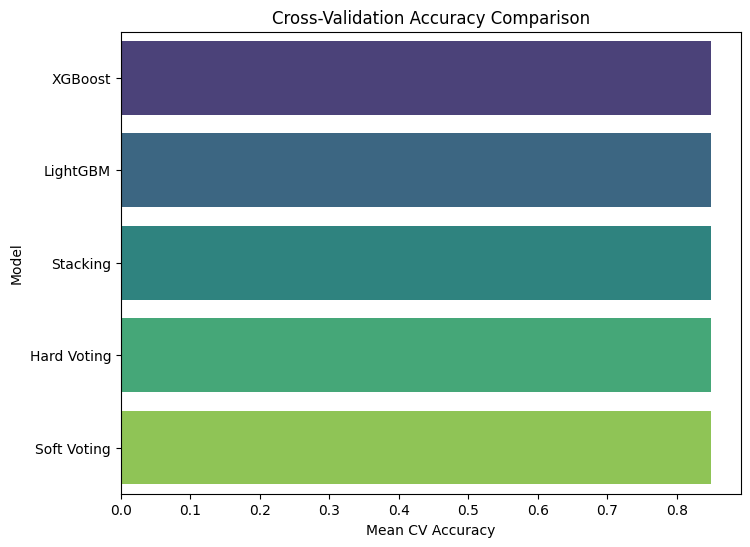

In [ ]:
print("\n--- Cross-Validation Scores ---")
models = {'Random Forest': rf, 'Gradient Boosting': gb, 'Stacking': stacking, 'Hard Voting': voting_hard, 'Soft Voting': voting_soft}
cv_results = {}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    cv_results[model_name] = scores.mean()
    print(f"{model_name}: Mean CV Accuracy = {scores.mean():.4f}")

# Compare cross-validation results visually
cv_df = pd.DataFrame(cv_results.items(), columns=['Model', 'Mean CV Accuracy'])
plt.figure(figsize=(8, 6))
sns.barplot(data=cv_df, x='Mean CV Accuracy', y='Model', palette='viridis')
plt.title("Cross-Validation Accuracy Comparison")
plt.show()

# Step 10: SHAP - Explainability

In [ ]:
print("\n--- SHAP Analysis ---")
explainer = shap.Explainer(rf, X_test)
shap_values = explainer(X_test)

# SHAP summary plot
shap.summary_plot(shap_values, X_test)


--- SHAP Analysis ---


# Step 11: LIME - Interpret Individual Predictions

In [ ]:
print("\n--- LIME Analysis ---")
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values,
                                                        feature_names=X.columns,
                                                        class_names=['0', '1', '2'],
                                                        discretize_continuous=True)

# test instance for LIME explanation
i = 0
lime_exp = lime_explainer.explain_instance(X_test.iloc[i].values, rf.predict_proba, num_features=5)
lime_exp.show_in_notebook(show_table=True)

# Final Results: Summary and Insights

In [ ]:
print("\n--- Final Performance Metrics ---")
metrics = pd.DataFrame(cv_results.items(), columns=['Model', 'Mean CV Accuracy'])
metrics = metrics.sort_values(by='Mean CV Accuracy', ascending=False)
print(metrics)